In [1]:
from sklearn.svm import LinearSVC
from sklearn import feature_extraction, model_selection, metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import string
#import gensim

In [2]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import math
import collections
from nltk.corpus import stopwords

In [3]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import networkx as nx
import spacy
from spacy.symbols import ORTH, LEMMA, POS
nlp = spacy.load('en_core_web_sm')
nlp.tokenizer.add_special_case("dont", [{ORTH: "dont", LEMMA: "dont", POS: "neg"}])
nlp.tokenizer.add_special_case("didnt", [{ORTH: "didnt", LEMMA: "didnt", POS: "neg"}])
nlp.tokenizer.add_special_case("isnt", [{ORTH: "isnt", LEMMA: "isnt", POS: "neg"}])
nlp.tokenizer.add_special_case("wasnt", [{ORTH: "wasnt", LEMMA: "wasnt", POS: "neg"}])
nlp.tokenizer.add_special_case("doesnt", [{ORTH: "doesnt", LEMMA: "doesnt", POS: "neg"}])
nlp.tokenizer.add_special_case("couldnt", [{ORTH: "couldnt", LEMMA: "couldnt", POS: "neg"}])
nlp.tokenizer.add_special_case("wouldnt", [{ORTH: "wouldnt", LEMMA: "wouldnt", POS: "neg"}])
nlp.tokenizer.add_special_case("cant", [{ORTH: "cant", LEMMA: "cant", POS: "neg"}])
nlp.tokenizer.add_special_case("cannot", [{ORTH: "cannot", LEMMA: "cannot", POS: "neg"}])
nlp.tokenizer.add_special_case("wont", [{ORTH: "wont", LEMMA: "wont", POS: "neg"}])
nlp.tokenizer.add_special_case("havent", [{ORTH: "havent", LEMMA: "havent", POS: "neg"}])
nlp.tokenizer.add_special_case("hadnt", [{ORTH: "hadnt", LEMMA: "hadnt", POS: "neg"}])

In [4]:
table = str.maketrans('', '', '!"#$%&\'()*+,-.:;<=>?@[\\]^_`{|}~' + "0123456789")
table2 = str.maketrans('/', ' ')
negWords = {'never','but','not','didn\'t','isn\'t','wasn\'t','doesn\'t','couldn\'t','didnt','isnt','wasnt','doesnt','couldnt'
   ,'wouldn\'t','wouldnt','don\'t','dont','can\'t','cant', 'cannot', 'wont', 'won\'t', 'havent', 'haven\'t', 'hadnt', 'hadn\'t'}
stopWords = set(stopwords.words('english')) - negWords
dataset = []
sentences = []
maxSentLen = 0
avgSentLen = 0
missingVectors = {}

In [5]:
word2vec = TfidfVectorizer(encoding='utf-8', ngram_range=(1, 3))

In [6]:
# with open('stopwords.txt') as file:
#     for line in file:
#         line = line.lower()
#         stopWords.append(line.strip())

In [7]:
def preprocess(text, aspectTerm=None, flag=None):
    text = text.replace("[comma]", "")
    text = text.replace("  ", " ")
    text = text.replace('"', '').replace('.','').replace('(',' ').replace('(','').replace(')','').replace('!','').replace("?",'').replace("  "," ")
    text = text.lstrip('- ')
    text = text.lstrip('_')    
    text = text.lstrip('_ ')
    text = text.lstrip('-')
    text = text.rstrip(' ')
    text = text.translate(table2)
    gw = lambda w: w.lower() if w.lower() in aspectTerm else w.translate(table).lower()
    if flag:
        x = aspectTerm.replace(" ","_")
        text = text.replace(aspectTerm,x)
        temp = text.split()
        try:
            atPos = temp.index(x)
        except ValueError:
            xx = x[0].replace("_", "")
            for w in temp:
                if x in w:
                    x = w
                    atPos = temp.index(x)
                    break
                if xx in w:
                    xx = w
                    atPos = temp.index(xx)
        return [text, x+'-'+str(atPos)]
    elif aspectTerm:
        text = [gw(word) for word in text.split() 
                if len(word) > 1 and (word.lower() in aspectTerm or word.translate(table).lower() not in stopWords)]
    else:
        text = [word.lower() for word in text.translate(table2).split() if len(word) > 1]
    return text

In [8]:
# should $numbers be removed ?

In [9]:
length = 0
ll = []
with open('data-2_train.csv') as file:
    file.readline()
    for line in file:
        data = line.split(",")
        data[2] = preprocess(data[2])
        data[1] = preprocess(data[1], data[2])
        sentences.append(preprocess(' '.join(data[1]), ' '.join(data[2]), True))
        data[-1] = data[-1].strip()
        length += len(data[1])
        ll.append(len(data[1]))
        if len(data[1]) > maxSentLen:
            maxSentLen = len(data[1])
        dataset.append(data)
avgSentLen = length / len(dataset)

In [10]:
Xtidf = word2vec.fit_transform(list(np.array(sentences)[:, 0]))

In [11]:
Xtidf.shape

(3602, 30444)

In [12]:
np.std(ll)

5.0778522959288575

In [13]:
print(maxSentLen, avgSentLen)
print(sorted(ll)[int(len(ll)/2)])

36 9.588839533592449
9


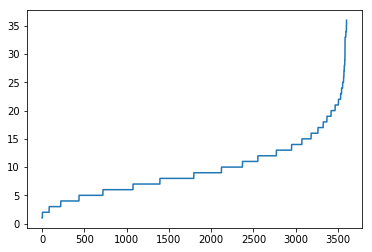

In [14]:
plt.plot(range(len(ll)), sorted(ll))
plt.show()

In [15]:
maxSentLen = 20

In [16]:
weD = 300
wvD = weD

In [17]:
posLex = set()
negLex = set()
with open('positive-words.txt') as file:
    for line in file:
        if len(line.strip()) > 0:
            posLex.add(line.strip())
with open('negative-words.txt') as file:
    for line in file:
        if len(line.strip()) > 0:
            negLex.add(line.strip())

In [18]:
def getSentGraph(sent):
    global nlp
    document = nlp(sent)

    # Load spacy's dependency tree into a networkx graph
    edges = []
    for token in document:
        # FYI https://spacy.io/docs/api/token
        for child in token.children:
            edges.append(('{0}-{1}'.format(token.lower_,token.i),
                          '{0}-{1}'.format(child.lower_,child.i)))

    return nx.Graph(edges)

In [19]:
X1 = []
y = []
yForSk = []
flag = "input"

In [20]:
# with open('chummada.txt', 'a') as ff:
#     for s in sentences:
#         ff.write(s[1]+'\n')

In [21]:
for i, data in enumerate(dataset):
    data1 = []
    meanAspVec = None
    
    #print(i)
    graph = getSentGraph(sentences[i][0])
    
    #if more than one word in aspect term, take mean
#     mean = np.zeros((weD, 1))
#     for w in data[2]:
#         twv = None
#         try:
#             if w in missingVectors:
#                 twv = missingVectors[w]
#             else:
#                 twv = word2vec[w].reshape(weD, 1)
#         except KeyError:
#             twv = np.random.normal(size=(weD, 1))/math.sqrt(weD+1)
#             missingVectors[w] = twv
#         mean += twv
#     meanAspVec = mean/len(data[2])
    
#     E = []
    
# #     for wv in data1:
# #         E.append(np.dot(wv.T, meanAspVec)/(np.linalg.norm(wv)) * np.linalg.norm(meanAspVec))
    
# #     E = np.array(E).reshape(300, 1)
# #     A = np.exp(E) / np.sum(np.exp(E))

#     for w in data[1]:
#         twv = None
#         try:
#             if w in missingVectors:
#                 twv = missingVectors[w]
#             else:
#                 twv = word2vec[w].reshape(weD, 1)
#         except KeyError:
#             twv = np.random.normal(size=(weD, 1))/math.sqrt(weD+1)
#             missingVectors[w] = twv
#         E.append(np.dot(twv.T, meanAspVec) / (np.linalg.norm(twv) * np.linalg.norm(meanAspVec)))

#     A = np.exp(E) / np.sum(np.exp(E)) # softmax
    
    tttemp = sentences[i][0].split()
    distVec = []
    for jj, w in enumerate(data[1]):
        if w in sentences[i][1]:
            dist = 0
#         elif w in negWords:
#             if 'not' in w:
#                 dist = 1/nx.shortest_path_length(graph, source=sentences[i][1], target='not-'+str(tttemp.index(w)))
#             elif 'nt' in w:
#                 dist = 1/nx.shortest_path_length(graph, source=sentences[i][1], target='nt-'+str(tttemp.index(w)))
#             elif 'n\'t' in w:
#                 dist = 1/nx.shortest_path_length(graph, source=sentences[i][1], target='n\'t-'+str(tttemp.index(w)))
        else:
            try:
                pD = nx.shortest_path_length(graph, source=sentences[i][1], target=w+'-'+str(tttemp.index(w)))
                dist = 1/pD
            except (nx.NetworkXNoPath, KeyError, nx.NetworkXError):
                dist = 1/maxSentLen
        distVec.append(dist)
#         twv = None
#         if w in missingVectors:
#             twv = missingVectors[w]
#         else:
#             twv = word2vec[w].reshape(weD, 1)
#         if flag == "attention":
#             data1.append(A[jj] * twv)
#         elif flag == "input":
#             data1.append(twv)

#     for w in data[1]:
#         twv = None
#         try:
#             if w in missingVectors:
#                 twv = missingVectors[w]
#             else:
#                 twv = word2vec[w].reshape(300, 1)
#         except KeyError:
#             twv = np.random.normal(size=(300, 1))/math.sqrt(301)
#             missingVectors[w] = twv
            
#         data1.append(np.vstack((twv, meanAspVec)))
    
    # creating lexicon score with window of 5 to the left and right of aspect
    lexScore = 0
    window = 5
    atPos = int(sentences[i][1].rsplit('-', maxsplit=1)[1])
    for lind in range(atPos - window, atPos):
        if lind >= 0:
            if data[1][lind] in posLex:
                lexScore += 1*distVec[lind]
            elif data[1][lind] in negLex or data[1][lind] in negWords:
                lexScore -= 1*distVec[lind]
    
    for lind in range(atPos + 1, atPos + window + 1):
        if lind >= len(data[1]):
            break
        else:
            if data[1][lind] in posLex:
                lexScore += 1*distVec[lind]
            elif data[1][lind] in negLex or data[1][lind] in negWords:
                lexScore -= 1*distVec[lind]

    if len(data[1]) < maxSentLen:
        j = len(data[1]) + 1
        while j <= maxSentLen:
            #data1.append(np.vstack((word2vec['#'].reshape(300, 1), meanAspVec)))
            #data1.append(np.vstack((np.zeros((300, 1)), meanAspVec)))
            #data1.append(np.zeros((wvD, 1)))
            distVec.append(1/maxSentLen)
            j += 1
    
    if len(data[1]) > maxSentLen:
        #del data1[maxSentLen:]
        del distVec[maxSentLen:]
    
    
#     ctr = 0
#     for lind in range(atPos - window, atPos):
#         if lind >= 0:
#             if data[1][lind] in posLex:
#                 lexScore += 1/(window - ctr)
#             elif data[1][lind] in negLex or data[1][lind] in negWords:
#                 lexScore -= 1/(window - ctr)
#         ctr += 1
    
#     ctr = 1
#     for lind in range(atPos + 1, atPos + window + 1):
#         if lind >= len(data[1]):
#             break
#         else:
#             if data[1][lind] in posLex:
#                 lexScore += 1/ctr
#             elif data[1][lind] in negLex or data[1][lind] in negWords:
#                 lexScore -= 1/ctr
#         ctr += 1
    
    
    #protoVec = np.array([np.mean(data1, axis=0)]).reshape(300,)
    
    protoVec = np.append(Xtidf[i].A[0], distVec)
    protoVec = np.append(protoVec, [lexScore])
    
    X1.append(protoVec)
    yForSk.append(data[-1])
    if data[-1] == '-1':
        y.append(np.array([[0.0, 0.0, 1.0]]))
    elif data[-1] == '0':
        y.append(np.array([[0.0, 1.0, 0.0]]))
    elif data[-1] == '1':
        y.append(np.array([[1.0, 0.0, 0.0]]))

X1 = np.array(X1)
y = np.array(y)
yForSk = np.array(yForSk)

In [22]:
sentences[44]

['little place cute interior_decor affordable city prices', 'interior_decor-3']

In [23]:
#print(Xtidf[0])

In [24]:
Xtidf[0].A.shape

(1, 30444)

In [25]:
X1.shape

(3602, 30465)

In [26]:
y.shape

(3602, 1, 3)

In [27]:
yForSk[[0, 1, 2]]

array(['-1', '1', '1'], 
      dtype='<U2')

In [28]:
kf = StratifiedKFold(n_splits=10, shuffle=True)

In [29]:
#train(X1, yForSk)


In [30]:
def printScores(accuracies, precisions, recalls, f1s):
    print("Average Scores:")
    print("Avg. accuracy=", np.sum(accuracies)/len(accuracies))
    print("Avg. precision=", np.sum(precisions, axis=0)/len(precisions))
    print("Avg. recall=", np.sum(recalls, axis=0)/len(recalls))
    print("Avg. f1=", np.sum(f1s, axis=0)/len(f1s))

In [31]:
#LinearSVC
accuracies = []
precisions = []
recalls = []
f1s = []

for index, (train_ind, test_ind) in enumerate(kf.split(X1, yForSk)):
    #print("Fold -", index)
    xtrain, xtest = X1[train_ind], X1[test_ind]
    ytrain, ytest = list(yForSk[train_ind]), list(yForSk[test_ind])
    
    clf=LinearSVC(C=1.0, multi_class='crammer_singer', max_iter=1000)
    #print(X_train.toarray())
    clf.fit(xtrain, ytrain)
    #print(log_reg.score(X_train, y_train))
    #print(log_reg.score(X_test, y_test))
    ypred = clf.predict(xtest)
    acc = np.mean(ytest == ypred)
    conf_matrix = confusion_matrix(ytest, ypred)
    #print(conf_matrix)
    #print(X_train.shape, X_train.shape)
    #print(precision_recall_fscore_support(ytest, ypred))
    stats = precision_recall_fscore_support(ytest, ypred, labels=['-1', '0', '1'])
    
    p = np.array([stats[0][2], stats[0][1], stats[0][0]])
    r = np.array([stats[1][2], stats[1][1], stats[1][0]])
    f = np.array([stats[2][2], stats[2][1], stats[2][0]])
    
    accuracies.append(acc)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f)
    
    #print("accuracy=", acc, "precision=", p, "recall=", r, "F1 Score=", f)
printScores(accuracies, precisions, recalls, f1s)

C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\s

Average Scores:
Avg. accuracy= 0.730966960851
Avg. precision= [ 0.80057947  0.53059129  0.62372409]
Avg. recall= [ 0.8932433   0.35233135  0.59259259]
Avg. f1= [ 0.84430209  0.42224506  0.60669784]


In [32]:
#Gaussian NB
from sklearn.naive_bayes import GaussianNB

accuracies = []
precisions = []
recalls = []
f1s = []

for index, (train_ind, test_ind) in enumerate(kf.split(X1, yForSk)):
    #print("Fold -", index)
    xtrain, xtest = X1[train_ind], X1[test_ind]
    ytrain, ytest = list(yForSk[train_ind]), list(yForSk[test_ind])
    
    gnb = GaussianNB()
    #print(X_train.toarray())
    gnb.fit(xtrain, ytrain)
    #print(log_reg.score(X_train, y_train))
    #print(log_reg.score(X_test, y_test))
    ypred = gnb.predict(xtest)
    acc = np.mean(ytest == ypred)
    conf_matrix = confusion_matrix(ytest, ypred)
    #print(conf_matrix)
    #print(X_train.shape, X_train.shape)
    #print(precision_recall_fscore_support(ytest, ypred))
    stats = precision_recall_fscore_support(ytest, ypred, labels=['-1', '0', '1'])
    
    p = np.array([stats[0][2], stats[0][1], stats[0][0]])
    r = np.array([stats[1][2], stats[1][1], stats[1][0]])
    f = np.array([stats[2][2], stats[2][1], stats[2][0]])
    
    accuracies.append(acc)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f)
    
    #print("accuracy=", acc, "precision=", p, "recall=", r, "F1 Score=", f)
printScores(accuracies, precisions, recalls, f1s)

Average Scores:
Avg. accuracy= 0.634076695972
Avg. precision= [ 0.82944056  0.34606505  0.52486647]
Avg. recall= [ 0.71534605  0.53080357  0.49679012]
Avg. f1= [ 0.76792669  0.41861991  0.50997626]


In [33]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

accuracies = []
precisions = []
recalls = []
f1s = []

for index, (train_ind, test_ind) in enumerate(kf.split(X1, yForSk)):
    #print("Fold -", index)
    xtrain, xtest = X1[train_ind], X1[test_ind]
    ytrain, ytest = list(yForSk[train_ind]), list(yForSk[test_ind])
    
    rfc = RandomForestClassifier(n_estimators=100, random_state=0)
    #print(X_train.toarray())
    rfc.fit(xtrain, ytrain)
    #print(log_reg.score(X_train, y_train))
    #print(log_reg.score(X_test, y_test))
    ypred = rfc.predict(xtest)
    acc = np.mean(ytest == ypred)
    conf_matrix = confusion_matrix(ytest, ypred)
    #print(conf_matrix)
    #print(X_train.shape, X_train.shape)
    #print(precision_recall_fscore_support(ytest, ypred))
    stats = precision_recall_fscore_support(ytest, ypred, labels=['-1', '0', '1'])
    
    p = np.array([stats[0][2], stats[0][1], stats[0][0]])
    r = np.array([stats[1][2], stats[1][1], stats[1][0]])
    f = np.array([stats[2][2], stats[2][1], stats[2][0]])
    
    accuracies.append(acc)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f)
    
    #print("accuracy=", acc, "precision=", p, "recall=", r, "F1 Score=", f)
printScores(accuracies, precisions, recalls, f1s)

Average Scores:
Avg. accuracy= 0.710962848482
Avg. precision= [ 0.73748585  0.54799839  0.6779456 ]
Avg. recall= [ 0.93852193  0.27943948  0.43847222]
Avg. f1= [ 0.82590621  0.36888336  0.53149285]


In [34]:
# #too slow and 0 neutral class f1 score
# from sklearn.svm import SVC

# accuracies = []
# precisions = []
# recalls = []
# f1s = []

# for index, (train_ind, test_ind) in enumerate(kf.split(X1, yForSk)):
#     #print("Fold -", index)
#     xtrain, xtest = X1[train_ind], X1[test_ind]
#     ytrain, ytest = list(yForSk[train_ind]), list(yForSk[test_ind])
    
#     clf=SVC(C=1.0, gamma='scale', decision_function_shape='ovr')
#     #print(X_train.toarray())
#     clf.fit(xtrain, ytrain)
#     #print(log_reg.score(X_train, y_train))
#     #print(log_reg.score(X_test, y_test))
#     ypred = clf.predict(xtest)
#     acc = np.mean(ytest == ypred)
#     conf_matrix = confusion_matrix(ytest, ypred)
#     print(conf_matrix)
#     #print(X_train.shape, X_train.shape)
#     #print(precision_recall_fscore_support(ytest, ypred))
#     stats = precision_recall_fscore_support(ytest, ypred, labels=[-1, 0, 1])
    
#     p = np.array([stats[0][2], stats[0][1], stats[0][0]])
#     r = np.array([stats[1][2], stats[1][1], stats[1][0]])
#     f = np.array([stats[2][2], stats[2][1], stats[2][0]])
    
#     accuracies.append(acc)
#     precisions.append(p)
#     recalls.append(r)
#     f1s.append(f)
    
#     print("accuracy=", acc, "precision=", p, "recall=", r, "F1 Score=", f)
# printScores(accuracies, precisions, recalls, f1s)

In [35]:
# testSents = []
# testDS = []

In [36]:
# with open('Data-1_test.csv') as file:
#     file.readline()
#     for line in file:
#         data = line.split(",")
#         data[2] = preprocess(data[2])
#         data[1] = preprocess(data[1], data[2])
#         testSents.append(preprocess(' '.join(data[1]), ' '.join(data[2]), True))
#         testDS.append(data)

In [37]:
# testXtidf = word2vec.transform(list(np.array(testSents)[:, 0]))

In [38]:
# xtest = []

In [39]:
# for i, data in enumerate(testDS):
#     data1 = []
#     meanAspVec = None
    
#     #print(i)
#     graph = getSentGraph(testSents[i][0])
    
#     #if more than one word in aspect term, take mean
# #     mean = np.zeros((weD, 1))
# #     for w in data[2]:
# #         twv = None
# #         try:
# #             if w in missingVectors:
# #                 twv = missingVectors[w]
# #             else:
# #                 twv = word2vec[w].reshape(weD, 1)
# #         except KeyError:
# #             twv = np.random.normal(size=(weD, 1))/math.sqrt(weD+1)
# #             missingVectors[w] = twv
# #         mean += twv
# #     meanAspVec = mean/len(data[2])
    
# #     E = []
    
# # #     for wv in data1:
# # #         E.append(np.dot(wv.T, meanAspVec)/(np.linalg.norm(wv)) * np.linalg.norm(meanAspVec))
    
# # #     E = np.array(E).reshape(300, 1)
# # #     A = np.exp(E) / np.sum(np.exp(E))

# #     for w in data[1]:
# #         twv = None
# #         try:
# #             if w in missingVectors:
# #                 twv = missingVectors[w]
# #             else:
# #                 twv = word2vec[w].reshape(weD, 1)
# #         except KeyError:
# #             twv = np.random.normal(size=(weD, 1))/math.sqrt(weD+1)
# #             missingVectors[w] = twv
# #         E.append(np.dot(twv.T, meanAspVec) / (np.linalg.norm(twv) * np.linalg.norm(meanAspVec)))

# #     A = np.exp(E) / np.sum(np.exp(E)) # softmax
    
#     tttemp = testSents[i][0].split()
#     distVec = []
#     for jj, w in enumerate(data[1]):
#         if w in testSents[i][1]:
#             dist = 0
# #         elif w in negWords:
# #             if 'not' in w:
# #                 dist = 1/nx.shortest_path_length(graph, source=sentences[i][1], target='not-'+str(tttemp.index(w)))
# #             elif 'nt' in w:
# #                 dist = 1/nx.shortest_path_length(graph, source=sentences[i][1], target='nt-'+str(tttemp.index(w)))
# #             elif 'n\'t' in w:
# #                 dist = 1/nx.shortest_path_length(graph, source=sentences[i][1], target='n\'t-'+str(tttemp.index(w)))
#         else:
#             try:
#                 pD = nx.shortest_path_length(graph, source=testSents[i][1], target=w+'-'+str(tttemp.index(w)))
# #                if pD <= 3:
#                 dist = 1/pD
# #                 else:
# #                     dist = 1/maxSentLen
#             except (nx.NetworkXNoPath, KeyError, nx.NetworkXError):
#                 dist = 1/maxSentLen
#         distVec.append(dist)
# #         twv = None
# #         if w in missingVectors:
# #             twv = missingVectors[w]
# #         else:
# #             twv = word2vec[w].reshape(weD, 1)
# #         if flag == "attention":
# #             data1.append(A[jj] * twv)
# #         elif flag == "input":
# #             data1.append(twv)

# #     for w in data[1]:
# #         twv = None
# #         try:
# #             if w in missingVectors:
# #                 twv = missingVectors[w]
# #             else:
# #                 twv = word2vec[w].reshape(300, 1)
# #         except KeyError:
# #             twv = np.random.normal(size=(300, 1))/math.sqrt(301)
# #             missingVectors[w] = twv
            
# #         data1.append(np.vstack((twv, meanAspVec)))
    
#     # creating lexicon score with window of 5 to the left and right of aspect
#     lexScore = 0
#     window = 4
#     atPos = int(testSents[i][1].rsplit('-', maxsplit=1)[1])
#     for lind in range(atPos - window, atPos):
#         if lind >= 0:
#             if data[1][lind] in posLex:
#                 lexScore += 1
#             elif data[1][lind] in negLex or data[1][lind] in negWords:
#                 lexScore -= 1
    
#     for lind in range(atPos + 1, atPos + window + 1):
#         if lind >= len(data[1]):
#             break
#         else:
#             if data[1][lind] in posLex:
#                 lexScore += 1
#             elif data[1][lind] in negLex or data[1][lind] in negWords:
#                 lexScore -= 1         

                
#     if len(data[1]) < maxSentLen:
#         j = len(data[1]) + 1
#         while j <= maxSentLen:
#             #data1.append(np.vstack((word2vec['#'].reshape(300, 1), meanAspVec)))
#             #data1.append(np.vstack((np.zeros((300, 1)), meanAspVec)))
#             #data1.append(np.zeros((wvD, 1)))
#             distVec.append(1/maxSentLen)
#             j += 1
    
#     if len(data[1]) > maxSentLen:
#         #del data1[maxSentLen:]
#         del distVec[maxSentLen:]
        
# #     ctr = 0
# #     for lind in range(atPos - window, atPos):
# #         if lind >= 0:
# #             if data[1][lind] in posLex:
# #                 lexScore += 1/(window - ctr)
# #             elif data[1][lind] in negLex or data[1][lind] in negWords:
# #                 lexScore -= 1/(window - ctr)
# #         ctr += 1
    
# #     ctr = 1
# #     for lind in range(atPos + 1, atPos + window + 1):
# #         if lind >= len(data[1]):
# #             break
# #         else:
# #             if data[1][lind] in posLex:
# #                 lexScore += 1/ctr
# #             elif data[1][lind] in negLex or data[1][lind] in negWords:
# #                 lexScore -= 1/ctr
# #         ctr += 1
    
    
#     #protoVec = np.array([np.mean(data1, axis=0)]).reshape(300,)
    
#     protoVec = np.append(testXtidf[i].A[0], distVec)
#     protoVec = np.append(protoVec, [lexScore])
    
#     xtest.append(protoVec)

# xtest = np.array(xtest)

In [40]:
# xtest.shape

In [41]:
# clf=LinearSVC(C=1.0, multi_class='crammer_singer', max_iter=10000)
# clf.fit(X1, yForSk)

In [42]:
# ypred = clf.predict(xtest)

In [43]:
# with open('testop3.txt', 'a') as ff:
#     for i in range(len(testDS)):
#         ff.write(testDS[i][0]+";;"+ypred[i]+'\n')

In [44]:
# accuracies = []
# precisions = []
# recalls = []
# f1s = []

# for index, (train_ind, test_ind) in enumerate(kf.split(X1, yForSk)):
#     print("Fold -", index)
#     xtrain, xtest = X1[train_ind], X1[test_ind]
#     ytrain, ytest = y[train_ind], y[test_ind]
    
#     model = train(xtrain, ytrain)
    
#     predictions = model.predict(xtest)
    
#     y_pred = tf.argmax(predictions, dimension=1)
#     y_test = tf.argmax(ytest.reshape(len(ytest), 3), dimension=1)
    
#     print("Labels=", np.unique(y_test, return_counts=True))
#     print("Predictions=", np.unique(y_pred, return_counts=True))
    
#     cm = confusion_matrix(y_test, y_pred)
#     numer = np.diag(cm)
#     numer = numer.astype(np.float64)
#     deno = np.sum(cm, axis = 1, dtype=np.float64)
#     recall = np.divide(numer, deno, out=np.zeros_like(numer), where=deno!=0)
#     deno = np.sum(cm, axis = 0, dtype=np.float64)
#     precision = np.divide(numer, deno, out=np.zeros_like(numer), where=deno!=0)
#     #loss, acc = model.evaluate(xtest, ytest)
#     nnum = (precision*recall)
#     ddeno = (precision+recall)
#     f1 = 2*np.divide(nnum, ddeno, out=np.zeros_like(nnum), where=ddeno!=0)
#     acc = np.sum(numer)/np.sum(deno)
    
#     accuracies.append(acc)
#     precisions.append(precision)
#     recalls.append(recall)
#     f1s.append(f1)
#     print("accuracy=", acc, "precision=", precision, "recall=", recall, "F1 Score=", f1)


In [45]:
#word2vec['#']#.reshape(300, 1) #numpy array
#print(word2vec.similarity('computer', 'laptop'))
#np.zeros(300).shape
#word2vec.distances(word2vec['computer'], other_words=["laptop"])
#np.append(word2vec["###GB"], np.array([1.0]))

In [46]:
# def tteest(text, aspectTerm):
#     aspectTerm = aspectTerm.replace("[comma]", "").replace("  ", " ").lower()
#     text = text.lower()
#     x = aspectTerm.replace(" ","_")
#     text = text.replace('"', '').replace('.','').replace('(',' ').replace('(','').replace(')','').replace('!','').replace("?",'').replace("  "," ").replace(aspectTerm,x)
#     text = text.lstrip('- ')
#     text = text.lstrip('_')    
#     text = text.lstrip('_ ')
#     text = text.lstrip('-')
#     text = text.rstrip(' ')
#     atPos = text.split().index(x)
#     return [text, x+'-'+str(atPos)]


# tteest("I also enjoy the fact that my MacBook Pro laptop allows me to run Windows 7 on it by using the VMWare program.","VMWare program")



In [47]:
# oma = []
# def chamma(line):
#     data = line.split(",")
#     data[2] = preprocess(data[2])
#     #print(data[2][0].replace("_", ""))
#     print(data[2])
#     data[1] = preprocess(data[1], data[2])
#     print(data[1])
#     oma.append(preprocess(' '.join(data[1]), ' '.join(data[2]), True))

# chamma("1805_1,Good for every day computing and web browsing.,every day computing,9--28,1")

In [48]:
# oma[0]

In [49]:
# corpus = ['This is the first document.',
#           'This document is the second document.',
#           'And this is the third one.',
#           'Is this the first document?']
# vectorizer = TfidfVectorizer(ngram_range=(1, 2))
# a = vectorizer.fit_transform(corpus)
# print(vectorizer.get_feature_names())